# Imports #

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression , Lasso , Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.svm import SVR, LinearSVR
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import joblib

# Preprocessing #

In [2]:
pricing = pd.read_csv('get_around_pricing_project.csv',index_col=0)

In [3]:
# Removal of outliers
upper_fence = 287
mask = (pricing['rental_price_per_day'] < upper_fence)
pricing = pricing.loc[mask,:]

In [4]:
# Feature engineering:

# pricing['mileage_2'] = pricing['mileage']**2
# pricing['mileage_ln'] = np.log(pricing['mileage'])
# pricing['engine_power_2'] = pricing['engine_power']**2
# pricing['engine_power_3'] = pricing['engine_power']**3
# pricing['mileage_engine_power'] = pricing['mileage']*pricing['engine_power']
# pricing['mileage_2_engine_power'] = pricing['mileage']**2 * pricing['engine_power']

# Remove missing values created by the logarithm:
# pricing.dropna(subset=['mileage_ln'], inplace=True)

print('All feature engineering were tested on XGBoost, the best model, and all of the decreased the R² for test.')

All feature engineering were tested on XGBoost, the best model, and all of the decreased the R² for test.


In [5]:
# Separate target variable Y from features X

print()
target_variable = "rental_price_per_day"
print("Target variable: ",target_variable)
Y = pricing.loc[:,target_variable]
print('Y : ')
print(Y.head())

features_list = pricing.drop(target_variable,axis=1).columns.tolist()
print("Features list: ",features_list)
X = pricing.loc[:,features_list]
print('X :')
print(X.head())
categorical_indices = [0,3,4,5,6,7,8,9,10,11,12]
numeric_indices = [1,2]


Target variable:  rental_price_per_day
Y : 
0    106
1    264
2    101
3    158
4    183
Name: rental_price_per_day, dtype: int64
Features list:  ['model_key', 'mileage', 'engine_power', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
X :
  model_key  mileage  engine_power    fuel paint_color     car_type  \
0   Citroën   140411           100  diesel       black  convertible   
1   Citroën    13929           317  petrol        grey  convertible   
2   Citroën   183297           120  diesel       white  convertible   
3   Citroën   128035           135  diesel         red  convertible   
4   Citroën    97097           160  diesel      silver  convertible   

   private_parking_available  has_gps  has_air_conditioning  automatic_car  \
0                       True     True                 False          False   
1                       True     True        

In [6]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [7]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first',categories='auto',handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features, auto for representations of all catego
    ])

# Applying pipeline on X variables depending on columns
feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = feature_encoder.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = feature_encoder.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
     model_key  mileage  engine_power    fuel paint_color   car_type  \
2039      Audi   187514           135  diesel        grey  hatchback   
901    Renault   161618           120  diesel       black     estate   
934    Peugeot   179647           100  diesel       black     estate   
2261  Mercedes    60013           100  diesel       white  hatchback   
3376  Mercedes   173888           100  diesel        blue      sedan   

      private_parking_available  has_gps  has_air_conditioning  automatic_car  \
2039                       True     True                 False          False   
901                        True     True                 False          False   
934                        True     True                 False          False   
2261                       True     True                 False          False   
3376                       True     True                 False          False   

      has_getaround_connect  has_speed

In [8]:
Y_train = Y_train.to_numpy().reshape(-1,1)
Y_test = Y_test.to_numpy().reshape(-1,1)

scaler = StandardScaler()

print("Preprocessing Y_train and Y_test")
Y_train = scaler.fit_transform(Y_train)
print(Y_train[0:5,:])
Y_test = scaler.transform(Y_test)
print(Y_test[0:5,:])

Preprocessing Y_train and Y_test
[[ 0.05997545]
 [-0.18322473]
 [-0.24402478]
 [-0.03122462]
 [-0.42642492]]
[[-0.76082518]
 [-0.06162464]
 [ 0.45517576]
 [-0.33522485]
 [-0.18322473]]


# MODELS #

In [9]:
# Models to be tested

models = [
    {
        'name': 'Linear Regression',
        'model': LinearRegression(),
        'params': {}
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {'alpha': [0.0, 0.1, 0.5, 1.0, 2, 3, 5, 10]} 
    },
    {
        'name': 'Ridge',
        'model': Ridge(),
        'params': {'alpha': [0.0, 0.1, 0.5, 1.0, 2, 3, 5, 10]}  
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [1, 2, 3, 4, 6, 8, 10, 12, 15, 20], 
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [1, 2, 4, 8]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor(),
        'params': {
            'max_depth': [4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 8],
            'n_estimators': [10, 20, 40, 60, 80, 100, 150, 200]
        }
    },
    {
        'name': 'SVR linear',
        'model': SVR(kernel='linear'),
        'params': {'C': [0.1, 1, 10]} 
    },
    {
        'name': 'SVR poly',
        'model': SVR(kernel='poly'),
        'params': {'degree': [2, 3, 4]} 
    },
    {
        'name': 'SVR rbf',
        'model': SVR(kernel='rbf'),
        'params': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}  # Adjusted C and gamma values
    },
    {
        'name': 'XGBoost',
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 150, 200, 300,500,1000], 
            'learning_rate': [0.5, 0.1, 0.05, 0.01, 0.005, 0.001],
            'max_depth': [4, 5, 7, 10],  
            'min_child_weight': [1, 2, 3], 
            'gamma': [0, 0.1, 0.2]
        }
    },
    {
    'name': 'CatBoost',
    'model': CatBoostRegressor(),
    'params': {
            'n_estimators': [300,500,100], 
            'learning_rate': [0.01, 0.05, 0.1,0.5,1],
            'depth': [5, 7, 10,12],
        }
    },

]


In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
results = []

# Iterate over models, doing a gridsearch for choosing the best params for each model. 
for model_info in models:
    model_name = model_info['name']
    model = model_info['model']
    params = model_info['params']
    grid_search = GridSearchCV(model, params, cv=5)
    grid_search.fit(X_train, Y_train)

    # Evaluation and storage of performance in a variable "results"
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    train_r2 = r2_score(Y_train, train_preds)
    test_r2 = r2_score(Y_test, test_preds)
    train_rmse = mean_squared_error(Y_train, train_preds, squared=False)
    test_rmse = mean_squared_error(Y_test, test_preds, squared=False)
    train_mape = mean_absolute_percentage_error(Y_train, train_preds)
    test_mape = mean_absolute_percentage_error(Y_test, test_preds)
    train_mae = mean_absolute_error(Y_train, train_preds)
    test_mae = mean_absolute_error(Y_test, test_preds)

    results.append({'Model': model_name,
                    'Train R2': train_r2,
                    'Test R2': test_r2,
                    'Train RMSE': train_rmse,
                    'Test RMSE': test_rmse,
                    'Train MAPE': train_mape,
                    'Test MAPE': test_mape,
                    'Train MAE': train_mae,
                    'Test MAE': test_mae,

                    
                    'Best Model': best_model,
                    'Best Params': best_params,
                    'Train Preds': train_preds,
                    'Test Preds': test_preds
                    })


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\elodi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408.1032097826469, tolerance: 0.3055177485376212
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\elodi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\elodi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

0:	learn: 0.9908198	total: 145ms	remaining: 14.3s
1:	learn: 0.9882562	total: 149ms	remaining: 7.29s
2:	learn: 0.9857335	total: 151ms	remaining: 4.87s
3:	learn: 0.9831537	total: 154ms	remaining: 3.69s
4:	learn: 0.9807193	total: 156ms	remaining: 2.97s
5:	learn: 0.9781455	total: 159ms	remaining: 2.5s
6:	learn: 0.9757406	total: 162ms	remaining: 2.16s
7:	learn: 0.9732462	total: 165ms	remaining: 1.9s
8:	learn: 0.9707383	total: 168ms	remaining: 1.7s
9:	learn: 0.9682283	total: 171ms	remaining: 1.54s
10:	learn: 0.9657687	total: 174ms	remaining: 1.41s
11:	learn: 0.9633675	total: 178ms	remaining: 1.3s
12:	learn: 0.9611013	total: 181ms	remaining: 1.21s
13:	learn: 0.9587012	total: 184ms	remaining: 1.13s
14:	learn: 0.9562227	total: 188ms	remaining: 1.06s
15:	learn: 0.9539134	total: 191ms	remaining: 1s
16:	learn: 0.9517978	total: 194ms	remaining: 945ms
17:	learn: 0.9494006	total: 196ms	remaining: 894ms
18:	learn: 0.9472133	total: 199ms	remaining: 849ms
19:	learn: 0.9449921	total: 202ms	remaining: 807

In [12]:
# Results storage in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:,:9]
sorted_results_df = results_df.sort_values(by='Test R2', ascending=False)
print(sorted_results_df)

               Model  Train R2   Test R2  Train RMSE  Test RMSE   Train MAPE  \
8            XGBoost  0.900990  0.793239    0.314658   0.454856  1025.743763   
4      Random Forest  0.888407  0.765294    0.334055   0.484620   977.082502   
7            SVR rbf  0.815154  0.750413    0.429937   0.499748   966.045391   
6           SVR poly  0.772811  0.736513    0.476643   0.513475   953.572925   
2              Ridge  0.729823  0.710901    0.519786   0.537852   382.920730   
1              Lasso  0.730129  0.710888    0.519491   0.537865   997.883947   
0  Linear Regression  0.730132  0.710874    0.519488   0.537878   383.460769   
5         SVR linear  0.716485  0.698792    0.532461   0.549001   962.468031   
3      Decision Tree  0.815974  0.668711    0.428982   0.575762   998.530691   
9           CatBoost  0.396040  0.367193    0.777148   0.795748   357.225674   

    Test MAPE  Train MAE  Test MAE  
8  968.657558   0.217841  0.297986  
4  928.692737   0.234344  0.319268  
7  931.6

# ENSEMBLE METHODS #

In [13]:
# Choose the best models for ensemble methods
top3_models = sorted_results_df['Model'].head(3).tolist()
print(top3_models)
# Retrieve the models from results, and their features
top3_result = [result for result in results if result['Model'] in top3_models]

['XGBoost', 'Random Forest', 'SVR rbf']


In [14]:
# Ensemble methods to test
ensemble_methods = [
    {'name': 'Voting', 'model': VotingRegressor, 'params': {'estimators': [(model['Model'], model['Best Model']) for model in top3_result]}},
    {'name': 'Stacking', 'model': StackingRegressor, 'params': {'estimators': [(model['Model'], model['Best Model']) for model in top3_result]}},
    {'name': 'Bagging', 'model': BaggingRegressor, 'params': {'base_estimator': top3_result[0]['Best Model']}},
    {'name': 'AdaBoosting', 'model': AdaBoostRegressor, 'params': {'base_estimator': top3_result[0]['Best Model']}},
    {'name': 'GradientBoosting', 'model': GradientBoostingRegressor, 'params': {'loss': 'ls'}}
]

In [15]:
# Iterate over ensemble methods:
ensemble_results = []

for ensemble_info in ensemble_methods:
    ensemble_name = ensemble_info['name']
    ensemble_model = ensemble_info['model']
    ensemble_params = ensemble_info.get('params', {})
    
    ensemble = ensemble_model(**ensemble_params)
    ensemble.fit(X_train, Y_train)
    
    train_r2 = r2_score(Y_train, ensemble.predict(X_train))
    test_r2 = r2_score(Y_test, ensemble.predict(X_test))
    
    ensemble_results.append({'Ensemble Method': ensemble_name, 'Train R2': train_r2, 'Test R2': test_r2})
    
    # Saving model
    model_filename = f'{ensemble_name}_model.joblib'
    joblib.dump({'ensemble': ensemble, 'model_filename': model_filename, 'feature_encoder': feature_encoder, 'scaler': scaler}, model_filename)
    print(f'Saved {ensemble_name} model to {model_filename}')


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\ensemble\_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saved Voting model to Voting_model.joblib


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\ensemble\_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saved Stacking model to Stacking_model.joblib


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Saved Bagging model to Bagging_model.joblib


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saved AdaBoosting model to AdaBoosting_model.joblib


c:\Users\elodi\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\elodi\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Saved GradientBoosting model to GradientBoosting_model.joblib


In [16]:
# Create a final DataFrame with the ensemble results
final_results_df = pd.DataFrame(ensemble_results)
sorted_final_results_df = final_results_df.sort_values(by='Test R2', ascending=False)
print(sorted_final_results_df)

    Ensemble Method  Train R2   Test R2
1          Stacking  0.898460  0.793588
0            Voting  0.882488  0.785069
3       AdaBoosting  0.900517  0.764810
2           Bagging  0.861914  0.757965
4  GradientBoosting  0.795627  0.750796


# Final Results #

In [17]:
print("The best R² test score is reached with a stacking ensemble.")

The best R² test score is reached with a stacking ensemble.


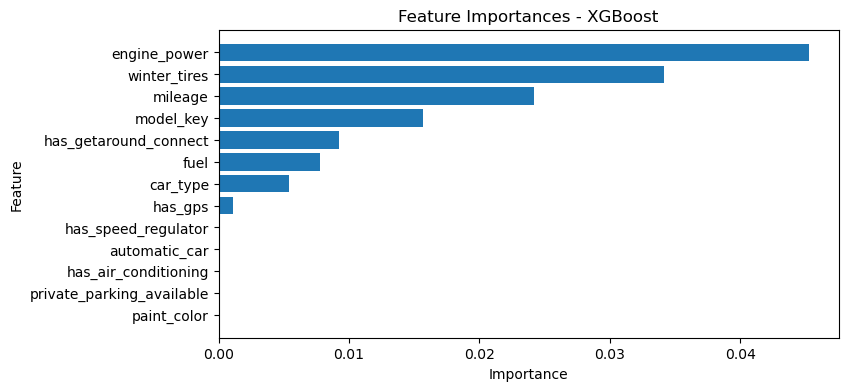

In [18]:
# Features importances

xgboost_model = [result['Best Model'] for result in results if result['Model'] == 'XGBoost'][0]
xgboost_model.fit(X_train, Y_train)
feature_importance = xgboost_model.feature_importances_
# Convert the sparse matrix to a dense matrix
X_train_dense = X_train.toarray()
original_feature_importance = feature_importance[:13]
feature_importance_df = pd.DataFrame({'Feature': features_list, 'Importance': original_feature_importance})
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
sorted_feature_importance = sorted_feature_importance_df['Importance'].values
sorted_feature_names = sorted_feature_importance_df['Feature'].values

# Plot the sorted feature importance
plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importances - XGBoost')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.show()